## (18+) Нахождение топ-10 слов в её песнях с помощью инструментов обработки естественного языка. 
### провел исследование: Киселев Илья

Воспользуемся парой библиотек.

In [1]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import squarify
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    LOC,
    NamesExtractor,
    DatesExtractor,
    MoneyExtractor,
    AddrExtractor,
    Doc
)

segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)
dates_extractor = DatesExtractor(morph_vocab)
money_extractor = MoneyExtractor(morph_vocab)
addr_extractor = AddrExtractor(morph_vocab)

Откроем файл, где содержатся все тексты песен Инстасамки.

In [2]:
file = open('analys_instasamka.txt')
text = file.read()

### Описание функций из библиотеки Natasha для анализа текста и определение задачи.

Задача - разбить слова на токены, а также найти синонимы. \
Использумые функции: \
1. segmenter: разделяет текст на токены и предложения, определяет свойства токенов. \
2. morph_tagger: для каждого токена извлеките теги с богатой морфологией. \
3. syntax_parser: для каждого предложения запускайте синтаксический анализатор. 

In [3]:
doc = Doc(text)
doc.segment(segmenter) 
doc.tag_morph(morph_tagger)
doc.parse_syntax(syntax_parser)

In [4]:
display(doc.tokens[:5])

[DocToken(stop=3, text='Сто', id='1_1', head_id='1_568', rel='nsubj', pos='NUM', feats=<Nom>),
 DocToken(start=4, stop=6, text='из', id='1_2', head_id='1_437', rel='case', pos='ADP'),
 DocToken(start=7, stop=10, text='ста', id='1_3', head_id='1_262', rel='nmod', pos='NUM', feats=<Gen>),
 DocToken(start=10, stop=11, text=',', id='1_4', head_id='1_254', rel='punct', pos='PUNCT'),
 DocToken(start=12, stop=17, text='Samka', id='1_5', head_id='1_663', rel='nsubj', pos='PROPN', feats=<Yes>)]

In [5]:
for token in doc.tokens:
    token.lemmatize(morph_vocab)

Теперь запишем все синонимы токенов в отдельную переменную, и уже над ней будем проводить очситку и анализ.

In [6]:
lemmas = [_.lemma for _ in doc.tokens]

Предварительная очистка слов от знаков препинания и некоторых стоп-слов.

In [7]:
i=0
lemmas_precorrected = []
while i < len(lemmas):
    if (lemmas[i] != ',') and (lemmas[i] != '—') and (lemmas[i] != ')') and (lemmas[i] != '(') \
    and (lemmas[i] != 'я') and  (lemmas[i] != 'на') and  (lemmas[i] != 'на') and  (lemmas[i] != '!') \
    and  (lemmas[i] != 'на')  and  (lemmas[i] != 'весь')  and  (lemmas[i] != 'это')  and  (lemmas[i] != 'твой') \
    and  (lemmas[i] != '?') and  (lemmas[i] != '’') and  (lemmas[i] != 'свой') and  (lemmas[i] != 'эй') \
    and  (lemmas[i] != ':') and  (lemmas[i] != '«') and (lemmas[i] != '»') and (lemmas[i] != '.') and (lemmas[i] != '?!'):
        lemmas_precorrected.append(lemmas[i])
        i += 1
    else:
        i += 1

Очистка данных от стоп-слов из пакета ntlk.

In [8]:
russian_stopwords = set(stopwords.words("russian"))
def remove_stopwords(tokens):
    cleaned_tokens = []
    for token in tokens:
        if token not in russian_stopwords:
            cleaned_tokens.append(token)
    return cleaned_tokens
lemmas_corrected = remove_stopwords(lemmas_precorrected)

Теперь, когда у нас есть токены, мы можем приступить к самому простому анализу. \
Подсчитаем количество слов через Counter. \
Выведем топ-10 популярных слов. 

In [9]:
def word_counter(tokens):
    word_counts = Counter()
    word_counts.update(tokens)
    return word_counts 

word_count = word_counter(lemmas_corrected)
word_count.most_common(10)

[('bitch', 209),
 ('money', 201),
 ('сука', 184),
 ('деньга', 156),
 ('mommy', 108),
 ('мама', 101),
 ('доллар', 101),
 ('купить', 99),
 ('знать', 87),
 ('делать', 79)]

На гистограме отобразим частоту появления слов в треках инстасамки.

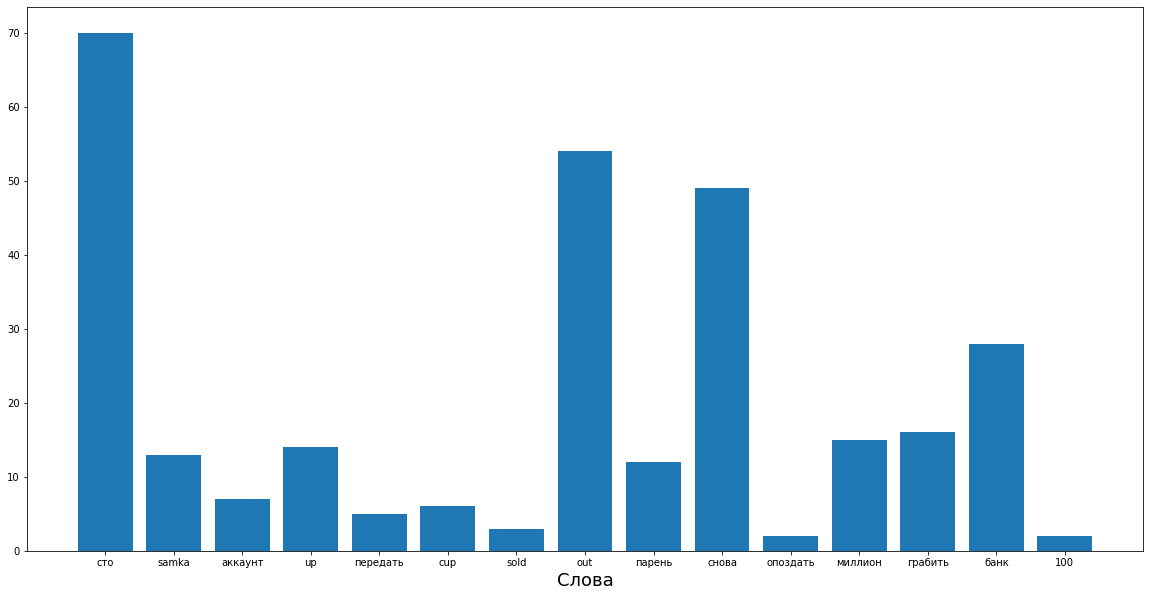

In [10]:
x = list(word_count.keys())[:15]
y = list(word_count.values())[:15]
plt.figure(figsize=(20, 10))
plt.bar(x, y)
plt.xlabel('Слова', fontsize=18)
plt.show();

Количество слов может быть полезно, но обычно требуется более глубокий анализ, 
отвечающий на наши вопросы, особенно когда данные состоят не из одного документа. 

Мы можем создать таблицу, создав Pandas DataFrame, содержащий функции, возвращающие: 
1. Количество токенов.
2. Их ранг по частотности употребления по отношению к другим токенам. 
3. Процент токенов от общего состава документа. 

In [11]:
temp = list(zip(word_count.keys(), word_count.values()))
wc = pd.DataFrame(temp, columns = ['word', 'count'])
wc['rank'] = wc['count'].rank(method='first', ascending=False)
total = wc['count'].sum()
wc['pct_total'] = wc['count'].apply(lambda x: x / total)
wc.sort_values('count', ascending=False).iloc[:10]

,word,count,rank,pct_total
16,bitch,209,1.0,0.015143
514,money,201,2.0,0.014563
45,сука,184,3.0,0.013331
42,деньга,156,4.0,0.011303
654,mommy,108,5.0,0.007825
198,доллар,101,7.0,0.007318
167,мама,101,6.0,0.007318
170,купить,99,8.0,0.007173
104,знать,87,9.0,0.006303
214,делать,79,10.0,0.005724


Как видно из стобцов count and rank самым популярным словом является 'bitch'.

Построим Cureemap, где уже наглядно будут видны популярные слова.

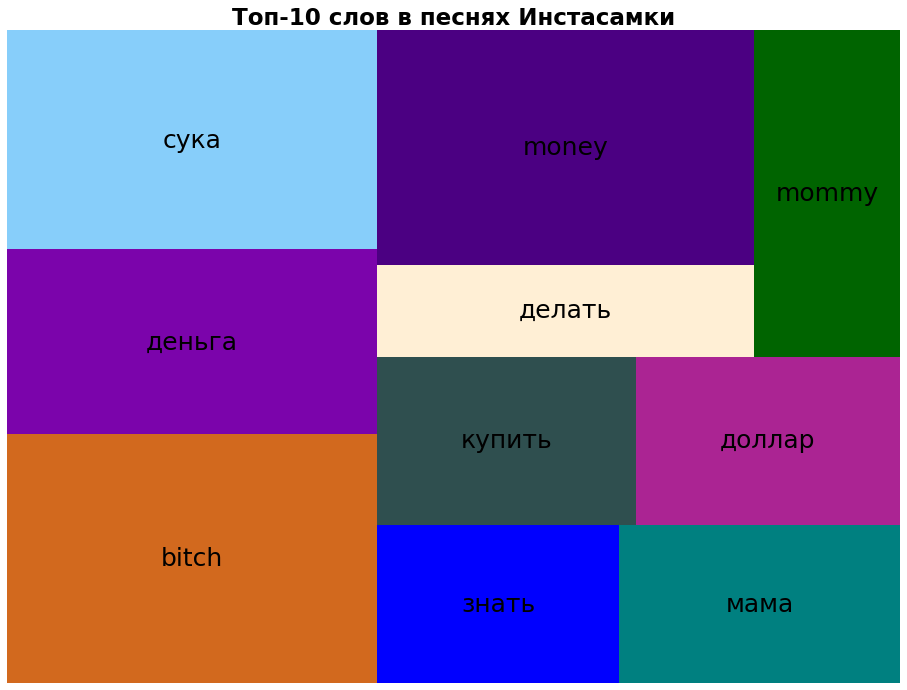

In [12]:
some_colors = ['#D2691E', '#7b04ab', '#87CEFA','#0000FF','#008080'\
              ,'#2F4F4F','#ab2493','#FFEFD5','#4B0082','#006400' \
              ,'#FFFF00','#7FFF00','#B22222','#FF8C00', '#3c548c']

fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 12)

wc_top20 = wc[wc['rank'] <= 10]
squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], \
        color=some_colors, \
        alpha=1, \
        text_kwargs={'fontsize':25})
plt.title("Топ-10 слов в песнях Инстасамки",fontsize=23,fontweight="bold")
plt.axis('off')
plt.show();

С помощью визуализации получилось представить, какие слова популярны.